In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


# Loading data train

In [16]:
data_train = pd.read_csv('air_pollution_train.csv')
data_train.head(5)

,Unnamed: 0,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var2(t)
0,1,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,148.0
1,2,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,159.0
2,3,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0
3,4,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0
4,5,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0


In [17]:
data_train.drop(['Unnamed: 0', 'var2(t)'], axis=1, inplace=True)

In [18]:
data_train.head(5)

,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
0,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0
1,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0
2,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0
3,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0
4,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0


In [19]:
label_encoder = LabelEncoder()
data_train.iloc[:,4] = label_encoder.fit_transform(data_train.iloc[:,4])

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train = scaler.fit_transform(data_train)

In [21]:
def series_to_supervised(data, input_lag=1, out_lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(input_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, out_lag):
        cols.append(df.shift(-i))
        if (i == 0):
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names
    
    if (dropnan):
        new_df.dropna(inplace=True)
    
    return new_df

# Lag 1

In [22]:
data_train_framed = series_to_supervised(data=data_train)

In [23]:
data_train_framed.drop(data_train_framed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


In [24]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var1(t)']]

# Loading data test

In [25]:
data_test = pd.read_csv('air_pollution_test.csv')

In [26]:
data_test.drop(['Unnamed: 0', 'var2(t)'], axis=1, inplace=True)

In [27]:
data_test.head(5)

,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
0,23.0,-20.0,7.0,1014.0,NW,137.67,0.0,0.0
1,24.0,-20.0,7.0,1014.0,NW,143.48,0.0,0.0
2,53.0,-20.0,7.0,1013.0,NW,147.50,0.0,0.0
3,65.0,-20.0,6.0,1013.0,NW,151.52,0.0,0.0
4,70.0,-20.0,6.0,1013.0,NW,153.31,0.0,0.0


In [28]:
data_test.iloc[:,4] = label_encoder.fit_transform(data_test.iloc[:,4])

In [29]:
data_test = pd.DataFrame(data=scaler.fit_transform(data_test), columns=data_test.columns)

In [30]:
data_test.head(5)

,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
0,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0
1,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0
2,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0
3,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0
4,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0


In [31]:
data_test_framed = series_to_supervised(data=data_test)

In [32]:
type(data_test)

pandas.core.frame.DataFrame

In [34]:
data_test_framed.drop(data_test_framed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0,0.035768
2,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0,0.078987
3,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0,0.096870
4,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0,0.104322
5,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0,0.117735


In [37]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y_validation = data_test_framed.loc[:,['var1(t)']]

In [38]:
x_validation = np.expand_dims(x_validation, axis=2)

In [39]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    
    return x_train, x_test, y_train, y_test

In [40]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [41]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(28030, 8) (7008, 8) (28030, 1) (7008, 1)


In [42]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28030, 8, 1) (7008, 8, 1)


In [43]:
stop_noimprovement = EarlyStopping(patience=10)

model = Sequential()

model.add(LSTM(50, input_shape=(8, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")

W0710 03:16:19.604210 139816635106944 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 03:16:19.635159 139816635106944 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 03:16:19.640282 139816635106944 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 03:16:19.945739 139816635106944 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

# Test/validation with 100 epochs

In [44]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0710 03:16:25.000968 139816635106944 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0710 03:16:25.908154 139816635106944 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 28030 samples, validate on 7008 samples
Epoch 1/100
 - 11s - loss: 0.0694 - val_loss: 0.0680
Epoch 2/100
 - 11s - loss: 0.0583 - val_loss: 0.0626
Epoch 3/100
 - 12s - loss: 0.0438 - val_loss: 0.0605
Epoch 4/100
 - 9s - loss: 0.0400 - val_loss: 0.0641
Epoch 5/100
 - 9s - loss: 0.0385 - val_loss: 0.0613
Epoch 6/100
 - 9s - loss: 0.0378 - val_loss: 0.0585
Epoch 7/100
 - 9s - loss: 0.0375 - val_loss: 0.0522
Epoch 8/100
 - 9s - loss: 0.0359 - val_loss: 0.0520
Epoch 9/100
 - 9s - loss: 0.0348 - val_loss: 0.0475
Epoch 10/100
 - 9s - loss: 0.0341 - val_loss: 0.0451
Epoch 11/100
 - 9s - loss: 0.0338 - val_loss: 0.0420
Epoch 12/100
 - 9s - loss: 0.0328 - val_loss: 0.0400
Epoch 13/100
 - 9s - loss: 0.0320 - val_loss: 0.0364
Epoch 14/100
 - 9s - loss: 0.0317 - val_loss: 0.0334
Epoch 15/100
 - 9s - loss: 0.0311 - val_loss: 0.0311
Epoch 16/100
 - 9s - loss: 0.0308 - val_loss: 0.0294
Epoch 17/100
 - 9s - loss: 0.0295 - val_loss: 0.0278
Epoch 18/100
 - 9s - loss: 0.0294 - val_loss: 0.0270
Epo

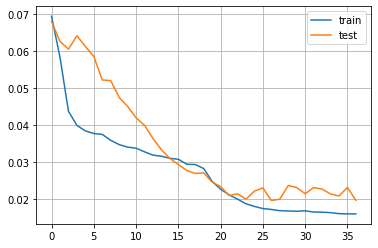

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
prediction = model.predict(x_test)

In [47]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03149


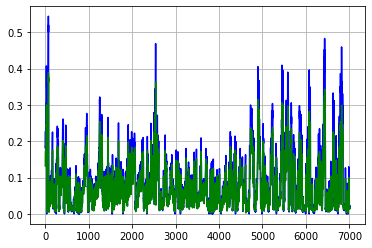

In [48]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [49]:
validation = model.predict(x_validation)

In [50]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05968


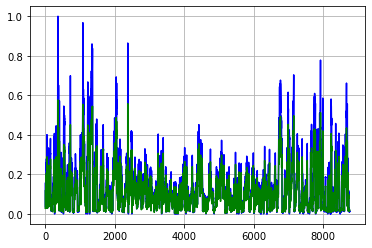

In [51]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [52]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28030 samples, validate on 7008 samples
Epoch 1/500
 - 9s - loss: 0.0157 - val_loss: 0.0213
Epoch 2/500
 - 9s - loss: 0.0162 - val_loss: 0.0205
Epoch 3/500
 - 9s - loss: 0.0161 - val_loss: 0.0210
Epoch 4/500
 - 9s - loss: 0.0160 - val_loss: 0.0225
Epoch 5/500
 - 9s - loss: 0.0159 - val_loss: 0.0197
Epoch 6/500
 - 9s - loss: 0.0158 - val_loss: 0.0198
Epoch 7/500
 - 9s - loss: 0.0160 - val_loss: 0.0227
Epoch 8/500
 - 9s - loss: 0.0158 - val_loss: 0.0231
Epoch 9/500
 - 9s - loss: 0.0160 - val_loss: 0.0239
Epoch 10/500
 - 9s - loss: 0.0158 - val_loss: 0.0205
Epoch 11/500
 - 9s - loss: 0.0157 - val_loss: 0.0220
Epoch 12/500
 - 9s - loss: 0.0155 - val_loss: 0.0230
Epoch 13/500
 - 9s - loss: 0.0156 - val_loss: 0.0207
Epoch 14/500
 - 9s - loss: 0.0155 - val_loss: 0.0221
Epoch 15/500
 - 9s - loss: 0.0154 - val_loss: 0.0227


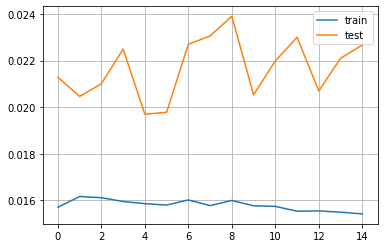

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
prediction = model.predict(x_test)

In [55]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03208


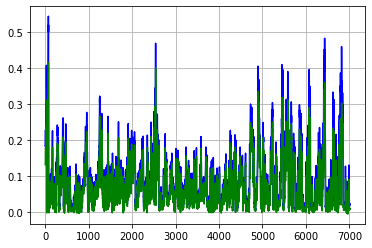

In [56]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [57]:
validation = model.predict(x_validation)

In [58]:
print('Test:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Test:
0.05562


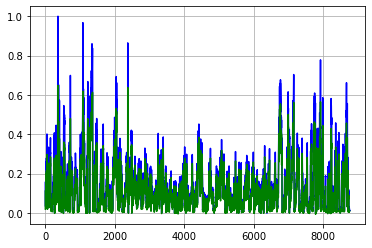

In [59]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [60]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28030 samples, validate on 7008 samples
Epoch 1/1000
 - 9s - loss: 0.0154 - val_loss: 0.0231
Epoch 2/1000
 - 9s - loss: 0.0156 - val_loss: 0.0213
Epoch 3/1000
 - 9s - loss: 0.0156 - val_loss: 0.0210
Epoch 4/1000
 - 9s - loss: 0.0156 - val_loss: 0.0226
Epoch 5/1000
 - 9s - loss: 0.0152 - val_loss: 0.0224
Epoch 6/1000
 - 9s - loss: 0.0155 - val_loss: 0.0237
Epoch 7/1000
 - 9s - loss: 0.0154 - val_loss: 0.0227
Epoch 8/1000
 - 9s - loss: 0.0154 - val_loss: 0.0256
Epoch 9/1000
 - 9s - loss: 0.0153 - val_loss: 0.0226
Epoch 10/1000
 - 9s - loss: 0.0153 - val_loss: 0.0222
Epoch 11/1000
 - 9s - loss: 0.0153 - val_loss: 0.0237
Epoch 12/1000
 - 9s - loss: 0.0154 - val_loss: 0.0241
Epoch 13/1000
 - 9s - loss: 0.0152 - val_loss: 0.0253


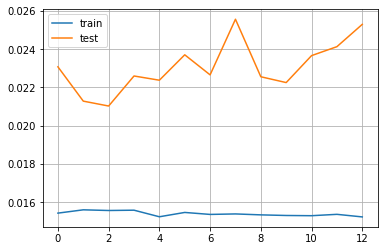

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
prediction = model.predict(x_test)

In [63]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03401


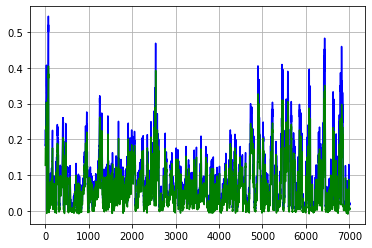

In [64]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [65]:
validation = model.predict(x_validation)

In [66]:
print('Test:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Test:
0.05838


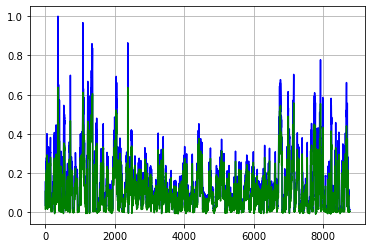

In [67]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Lag 5

In [68]:
#data_train_framed.head(5)

In [69]:
data_train_framed = series_to_supervised(data=data_train, out_lag=5)
data_train_framed.head(8)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.295082,...,0.074074,0.0,0.109658,0.426230,0.216667,0.563636,0.666667,0.011433,0.111111,0.0
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.360656,...,0.111111,0.0,0.105634,0.426230,0.216667,0.581818,0.666667,0.014492,0.148148,0.0
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.426230,...,0.148148,0.0,0.124748,0.426230,0.233333,0.600000,0.666667,0.017551,0.000000,0.0
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.426230,...,0.000000,0.0,0.120724,0.409836,0.216667,0.600000,0.666667,0.020610,0.000000,0.0
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.426230,...,0.000000,0.0,0.132797,0.426230,0.233333,0.618182,0.666667,0.023669,0.000000,0.0
6,0.109658,0.426230,0.216667,0.563636,0.666667,0.011433,0.111111,0.0,0.105634,0.426230,...,0.000000,0.0,0.140845,0.426230,0.233333,0.636364,0.666667,0.029018,0.037037,0.0
7,0.105634,0.426230,0.216667,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.426230,...,0.037037,0.0,0.152918,0.409836,0.233333,0.636364,0.666667,0.034367,0.000000,0.0
8,0.124748,0.426230,0.233333,0.600000,0.666667,0.017551,0.000000,0.0,0.120724,0.409836,...,0.000000,0.0,0.148893,0.409836,0.233333,0.636364,0.666667,0.039716,0.000000,0.0


In [70]:
data_train_framed.drop(data_train_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
    25,26,27,28,29,30,31,32,33,34,35,36,
    37,38,39,41,42,43,44,45,46,47
]], axis=1, inplace=True)

data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t+4)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.109658
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.105634
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.124748
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.120724
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.132797


In [71]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var1(t+4)']]

In [72]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [73]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28027, 8, 1) (7007, 8, 1)


In [74]:
print(x.shape, x_test.shape)

(35034, 8) (7007, 8, 1)


In [75]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(28027, 8, 1) (7007, 8, 1) (28027, 1) (7007, 1)


In [76]:
data_test_framed = series_to_supervised(data=data_test, out_lag=5)
data_test_framed.head(8)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
1,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0,0.035768,0.307692,...,0.0,0.0,0.117735,0.338462,0.290909,0.413043,1.000000,0.000998,0.0,0.0
2,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0,0.078987,0.307692,...,0.0,0.0,0.137109,0.338462,0.309091,0.413043,0.333333,0.008100,0.0,0.0
3,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0,0.096870,0.307692,...,0.0,0.0,0.157973,0.323077,0.345455,0.413043,0.333333,0.019263,0.0,0.0
4,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0,0.104322,0.307692,...,0.0,0.0,0.111773,0.323077,0.345455,0.434783,0.333333,0.035487,0.0,0.0
5,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0,0.117735,0.338462,...,0.0,0.0,0.086438,0.338462,0.345455,0.434783,0.333333,0.048669,0.0,0.0
6,0.117735,0.338462,0.290909,0.413043,1.000000,0.000998,0.0,0.0,0.137109,0.338462,...,0.0,0.0,0.049180,0.338462,0.363636,0.456522,0.333333,0.059833,0.0,0.0
7,0.137109,0.338462,0.309091,0.413043,0.333333,0.008100,0.0,0.0,0.157973,0.323077,...,0.0,0.0,0.076006,0.338462,0.381818,0.478261,0.333333,0.070996,0.0,0.0
8,0.157973,0.323077,0.345455,0.413043,0.333333,0.019263,0.0,0.0,0.111773,0.323077,...,0.0,0.0,0.047690,0.338462,0.400000,0.478261,0.333333,0.089261,0.0,0.0


In [77]:
data_test_framed.drop(data_test_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
    25,26,27,28,29,30,31,32,33,34,35,36,
    37,38,39,41,42,43,44,45,46,47
]], axis=1, inplace=True)

data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t+4)
1,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0,0.117735
2,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0,0.137109
3,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0,0.157973
4,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0,0.111773
5,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0,0.086438


In [79]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y_validation = data_test_framed.loc[:,['var1(t+4)']]

In [80]:
x_validation = np.expand_dims(x_validation, axis=2)

# Test/validation with 100 epochs

In [81]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28027 samples, validate on 7007 samples
Epoch 1/100
 - 10s - loss: 0.0374 - val_loss: 0.0340
Epoch 2/100
 - 9s - loss: 0.0373 - val_loss: 0.0337
Epoch 3/100
 - 9s - loss: 0.0371 - val_loss: 0.0336
Epoch 4/100
 - 9s - loss: 0.0370 - val_loss: 0.0334
Epoch 5/100
 - 9s - loss: 0.0368 - val_loss: 0.0334
Epoch 6/100
 - 9s - loss: 0.0369 - val_loss: 0.0333
Epoch 7/100
 - 9s - loss: 0.0369 - val_loss: 0.0337
Epoch 8/100
 - 9s - loss: 0.0369 - val_loss: 0.0332
Epoch 9/100
 - 9s - loss: 0.0369 - val_loss: 0.0334
Epoch 10/100
 - 9s - loss: 0.0367 - val_loss: 0.0333
Epoch 11/100
 - 9s - loss: 0.0368 - val_loss: 0.0334
Epoch 12/100
 - 9s - loss: 0.0367 - val_loss: 0.0331
Epoch 13/100
 - 9s - loss: 0.0366 - val_loss: 0.0331
Epoch 14/100
 - 9s - loss: 0.0366 - val_loss: 0.0333
Epoch 15/100
 - 9s - loss: 0.0365 - val_loss: 0.0334
Epoch 16/100
 - 9s - loss: 0.0365 - val_loss: 0.0333
Epoch 17/100
 - 9s - loss: 0.0364 - val_loss: 0.0332
Epoch 18/100
 - 9s - loss: 0.0363 - val_loss: 0.0332
Epoch

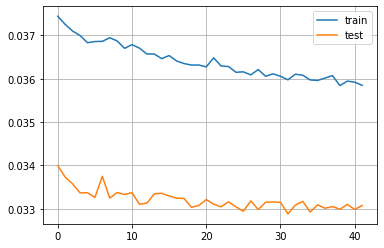

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
prediction = model.predict(x_test)

In [84]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05087


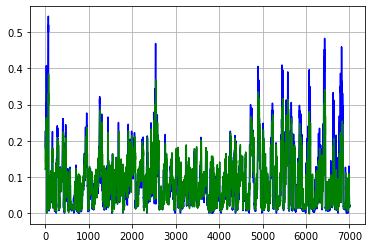

In [85]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [86]:
validation = model.predict(x_validation)

In [87]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.08832


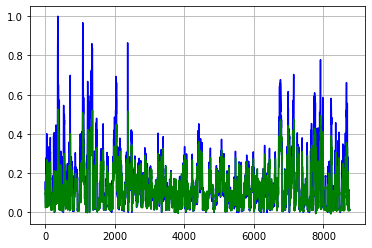

In [88]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [89]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28027 samples, validate on 7007 samples
Epoch 1/500
 - 9s - loss: 0.0358 - val_loss: 0.0330
Epoch 2/500
 - 9s - loss: 0.0359 - val_loss: 0.0330
Epoch 3/500
 - 9s - loss: 0.0359 - val_loss: 0.0330
Epoch 4/500
 - 9s - loss: 0.0358 - val_loss: 0.0331
Epoch 5/500
 - 9s - loss: 0.0357 - val_loss: 0.0330
Epoch 6/500
 - 9s - loss: 0.0357 - val_loss: 0.0333
Epoch 7/500
 - 9s - loss: 0.0358 - val_loss: 0.0330
Epoch 8/500
 - 9s - loss: 0.0358 - val_loss: 0.0331
Epoch 9/500
 - 9s - loss: 0.0359 - val_loss: 0.0330
Epoch 10/500
 - 9s - loss: 0.0357 - val_loss: 0.0338
Epoch 11/500
 - 9s - loss: 0.0356 - val_loss: 0.0332
Epoch 12/500
 - 9s - loss: 0.0358 - val_loss: 0.0330
Epoch 13/500
 - 9s - loss: 0.0357 - val_loss: 0.0332
Epoch 14/500
 - 9s - loss: 0.0356 - val_loss: 0.0332
Epoch 15/500
 - 9s - loss: 0.0356 - val_loss: 0.0331
Epoch 16/500
 - 9s - loss: 0.0355 - val_loss: 0.0330
Epoch 17/500
 - 9s - loss: 0.0355 - val_loss: 0.0334
Epoch 18/500
 - 9s - loss: 0.0357 - val_loss: 0.0331
Epoch 

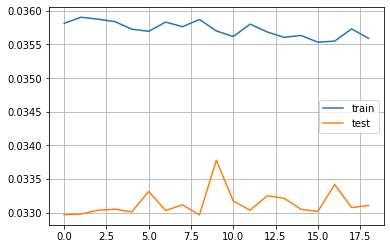

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
prediction = model.predict(x_test)

In [92]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05076


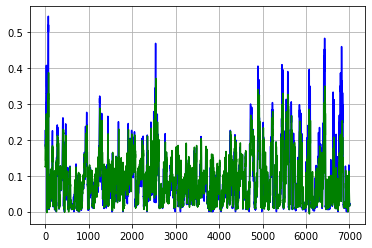

In [93]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [94]:
validation = model.predict(x_validation)

In [95]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.08773


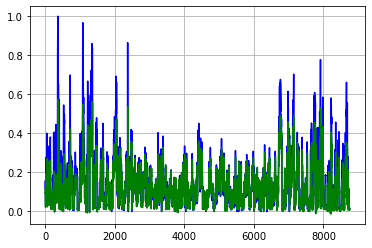

In [96]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [97]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28027 samples, validate on 7007 samples
Epoch 1/1000
 - 9s - loss: 0.0356 - val_loss: 0.0330
Epoch 2/1000
 - 9s - loss: 0.0356 - val_loss: 0.0333
Epoch 3/1000
 - 9s - loss: 0.0357 - val_loss: 0.0332
Epoch 4/1000
 - 9s - loss: 0.0356 - val_loss: 0.0333
Epoch 5/1000
 - 9s - loss: 0.0356 - val_loss: 0.0333
Epoch 6/1000
 - 9s - loss: 0.0356 - val_loss: 0.0328
Epoch 7/1000
 - 9s - loss: 0.0355 - val_loss: 0.0334
Epoch 8/1000
 - 9s - loss: 0.0354 - val_loss: 0.0331
Epoch 9/1000
 - 9s - loss: 0.0355 - val_loss: 0.0332
Epoch 10/1000
 - 9s - loss: 0.0354 - val_loss: 0.0331
Epoch 11/1000
 - 9s - loss: 0.0355 - val_loss: 0.0330
Epoch 12/1000
 - 9s - loss: 0.0354 - val_loss: 0.0330
Epoch 13/1000
 - 9s - loss: 0.0354 - val_loss: 0.0334
Epoch 14/1000
 - 9s - loss: 0.0356 - val_loss: 0.0334
Epoch 15/1000
 - 10s - loss: 0.0354 - val_loss: 0.0330
Epoch 16/1000
 - 9s - loss: 0.0355 - val_loss: 0.0332


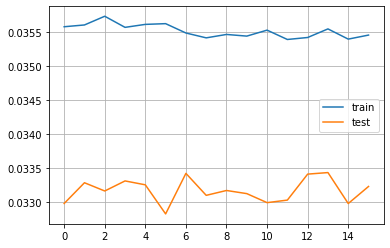

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
prediction = model.predict(x_test)

In [100]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05057


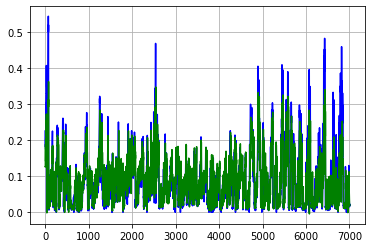

In [101]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [102]:
validation = model.predict(x_validation)

In [103]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.08841


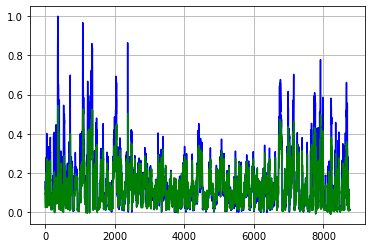

In [104]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Lag 10

In [105]:
data_train_framed = series_to_supervised(data=data_train, out_lag=10)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.295082,...,0.000000,0.0,0.140845,0.426230,0.233333,0.636364,0.666667,0.029018,0.037037,0.0
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.360656,...,0.037037,0.0,0.152918,0.409836,0.233333,0.636364,0.666667,0.034367,0.000000,0.0
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.426230,...,0.000000,0.0,0.148893,0.409836,0.233333,0.636364,0.666667,0.039716,0.000000,0.0
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.426230,...,0.000000,0.0,0.164990,0.409836,0.233333,0.618182,0.666667,0.046586,0.000000,0.0
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.426230,...,0.000000,0.0,0.158954,0.393443,0.233333,0.618182,0.666667,0.053456,0.000000,0.0


In [106]:
data_train_framed.drop(data_train_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
    38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,
    68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87
]], axis=1, inplace=True)

data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t+9)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.140845
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.152918
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.148893
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.164990
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.158954


In [107]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var1(t+9)']]

In [108]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [109]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28023, 8, 1) (7006, 8, 1)


In [110]:
data_test_framed = series_to_supervised(data=data_test, out_lag=10)

In [111]:
data_test_framed.drop(data_test_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
    38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,
    68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87
]], axis=1, inplace=True)

data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t+9)
1,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0,0.049180
2,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0,0.076006
3,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0,0.047690
4,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0,0.034277
5,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0,0.041729


In [112]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y_validation = data_test_framed.loc[:,['var1(t+9)']]

In [113]:
x_validation = np.expand_dims(x_validation, axis=2)

# Test/validation with 100 epochs

In [114]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28023 samples, validate on 7006 samples
Epoch 1/100
 - 10s - loss: 0.0491 - val_loss: 0.0447
Epoch 2/100
 - 10s - loss: 0.0490 - val_loss: 0.0449
Epoch 3/100
 - 9s - loss: 0.0489 - val_loss: 0.0444
Epoch 4/100
 - 9s - loss: 0.0487 - val_loss: 0.0452
Epoch 5/100
 - 9s - loss: 0.0486 - val_loss: 0.0444
Epoch 6/100
 - 9s - loss: 0.0486 - val_loss: 0.0449
Epoch 7/100
 - 9s - loss: 0.0486 - val_loss: 0.0446
Epoch 8/100
 - 10s - loss: 0.0485 - val_loss: 0.0441
Epoch 9/100
 - 9s - loss: 0.0485 - val_loss: 0.0450
Epoch 10/100
 - 9s - loss: 0.0483 - val_loss: 0.0448
Epoch 11/100
 - 9s - loss: 0.0484 - val_loss: 0.0454
Epoch 12/100
 - 9s - loss: 0.0485 - val_loss: 0.0448
Epoch 13/100
 - 9s - loss: 0.0484 - val_loss: 0.0451
Epoch 14/100
 - 9s - loss: 0.0484 - val_loss: 0.0445
Epoch 15/100
 - 9s - loss: 0.0483 - val_loss: 0.0452
Epoch 16/100
 - 9s - loss: 0.0483 - val_loss: 0.0445
Epoch 17/100
 - 9s - loss: 0.0482 - val_loss: 0.0450
Epoch 18/100
 - 9s - loss: 0.0483 - val_loss: 0.0444


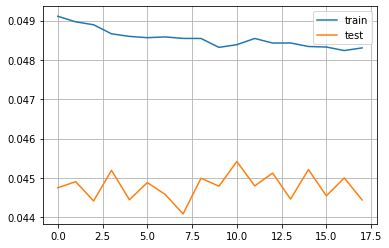

In [115]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
prediction = model.predict(x_test)

In [117]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06383


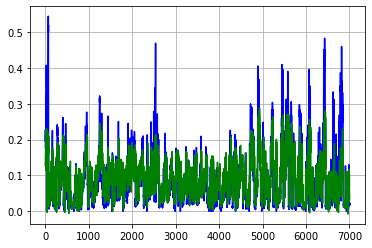

In [118]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [119]:
validation = model.predict(x_validation)

In [120]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.11348


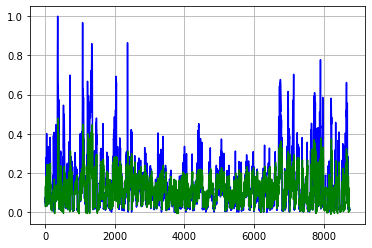

In [121]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [122]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28023 samples, validate on 7006 samples
Epoch 1/500
 - 9s - loss: 0.0483 - val_loss: 0.0444
Epoch 2/500
 - 9s - loss: 0.0482 - val_loss: 0.0444
Epoch 3/500
 - 9s - loss: 0.0482 - val_loss: 0.0449
Epoch 4/500
 - 9s - loss: 0.0482 - val_loss: 0.0444
Epoch 5/500
 - 9s - loss: 0.0482 - val_loss: 0.0448
Epoch 6/500
 - 9s - loss: 0.0481 - val_loss: 0.0445
Epoch 7/500
 - 9s - loss: 0.0482 - val_loss: 0.0449
Epoch 8/500
 - 9s - loss: 0.0482 - val_loss: 0.0446
Epoch 9/500
 - 9s - loss: 0.0482 - val_loss: 0.0441
Epoch 10/500
 - 9s - loss: 0.0481 - val_loss: 0.0449
Epoch 11/500
 - 9s - loss: 0.0481 - val_loss: 0.0445
Epoch 12/500
 - 9s - loss: 0.0481 - val_loss: 0.0443
Epoch 13/500
 - 9s - loss: 0.0481 - val_loss: 0.0446
Epoch 14/500
 - 9s - loss: 0.0482 - val_loss: 0.0445
Epoch 15/500
 - 9s - loss: 0.0480 - val_loss: 0.0441
Epoch 16/500
 - 9s - loss: 0.0482 - val_loss: 0.0444
Epoch 17/500
 - 9s - loss: 0.0481 - val_loss: 0.0440
Epoch 18/500
 - 9s - loss: 0.0479 - val_loss: 0.0443
Epoch 

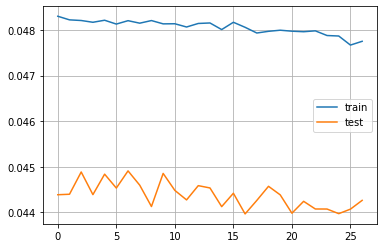

In [123]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
prediction = model.predict(x_test)

In [125]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06357


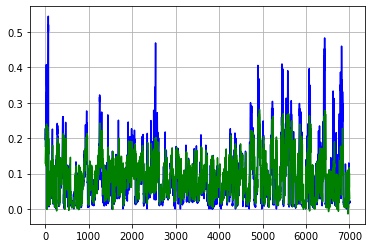

In [126]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [127]:
validation = model.predict(x_validation)

In [128]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.1129


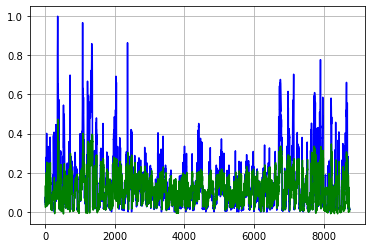

In [129]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [130]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28023 samples, validate on 7006 samples
Epoch 1/1000
 - 9s - loss: 0.0479 - val_loss: 0.0440
Epoch 2/1000
 - 9s - loss: 0.0479 - val_loss: 0.0440
Epoch 3/1000
 - 9s - loss: 0.0478 - val_loss: 0.0439
Epoch 4/1000
 - 9s - loss: 0.0478 - val_loss: 0.0439
Epoch 5/1000
 - 9s - loss: 0.0479 - val_loss: 0.0440
Epoch 6/1000
 - 9s - loss: 0.0477 - val_loss: 0.0439
Epoch 7/1000
 - 9s - loss: 0.0477 - val_loss: 0.0436
Epoch 8/1000
 - 9s - loss: 0.0478 - val_loss: 0.0438
Epoch 9/1000
 - 9s - loss: 0.0478 - val_loss: 0.0438
Epoch 10/1000
 - 9s - loss: 0.0478 - val_loss: 0.0436
Epoch 11/1000
 - 9s - loss: 0.0477 - val_loss: 0.0437
Epoch 12/1000
 - 9s - loss: 0.0476 - val_loss: 0.0435
Epoch 13/1000
 - 9s - loss: 0.0477 - val_loss: 0.0438
Epoch 14/1000
 - 9s - loss: 0.0477 - val_loss: 0.0439
Epoch 15/1000
 - 9s - loss: 0.0477 - val_loss: 0.0438
Epoch 16/1000
 - 9s - loss: 0.0478 - val_loss: 0.0437
Epoch 17/1000
 - 9s - loss: 0.0476 - val_loss: 0.0436
Epoch 18/1000
 - 9s - loss: 0.0475 - val_l

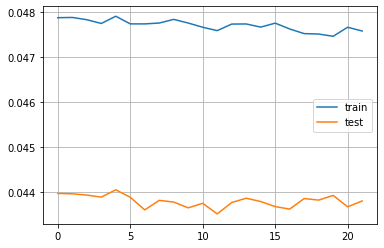

In [131]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
prediction = model.predict(x_test)

In [133]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06356


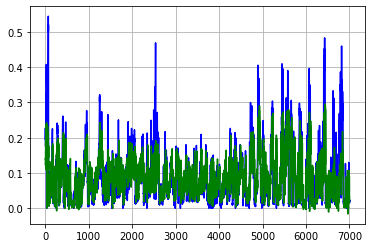

In [134]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [135]:
validation = model.predict(x_validation)

In [136]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.11276


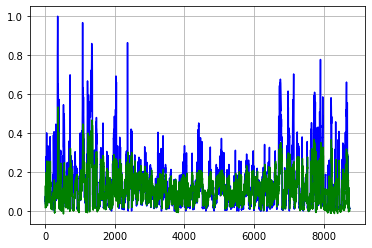

In [137]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)